In [2]:
import numpyro
cpu_cores = 8
numpyro.set_host_device_count(cpu_cores)

In [11]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import tinygp

# stingray imports
from stingray.modeling.gpmodeling import (
    get_gp_params,
    get_kernel,
    get_mean,
)

# inference imports
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
# import arviz for analysis
import arviz as az

# for style
plt.style.use("https://github.com/mlefkir/beauxgraphs/raw/main/beautifulgraphs_colblind.mplstyle")

First, let's load the time series

In [4]:
t,y,yerr = np.genfromtxt("simu_12.txt", unpack=True)

In [5]:
kernel_type = "PowL"
mean_type = "constant"
kernel_params = get_gp_params(kernel_type,mean_type,scale_errors=True,log_transform=True)
print(f"parameters : {kernel_params}")

parameters : ['alpha_1', 'log_f_bend', 'alpha_2', 'variance', 'A', 'scale_err', 'log_shift']


Define an inference model with NumPyro

In [9]:
muL = jnp.log(np.var(y))-0.5

def numpyro_model(t, yerr, y):
    f_min, f_max = 1 / (t[-1] - t[0]), 1 / (2 * jnp.min(jnp.diff(t)))
    S_low = 2
    S_high = 2
    n_approx_components = 15
    approximate_with = "SHO"

    # Priors
    alpha_1 = numpyro.sample("alpha_1", dist.Uniform(0, 1.5))
    f_1 = numpyro.sample("log_f_1", dist.Uniform(jnp.log(f_min), jnp.log(f_max)))
    alpha_2 = numpyro.sample("alpha_2", dist.Uniform(1.5, 4))

    variance = numpyro.sample("variance", dist.LogNormal(muL, 1.0))
    mu = numpyro.sample("mu", dist.Normal(0.0, 2.0))
    nu = numpyro.sample("nu", dist.Gamma(2, 2))

    param_dict = {
        "alpha_1": alpha_1,
        "f_bend": jnp.exp(f_1),
        "alpha_2": alpha_2,
        "variance": variance,
        "A": mu,
        "scale_err": nu,
    }

    # get the kernel

    kernel = get_kernel(
        kernel_type="PowL",
        kernel_params=param_dict,
        f_min=f_min,
        f_max=f_max,
        n_approx_components=n_approx_components,
        approximate_with=approximate_with,
        S_low=S_low,
        S_high=S_high,
    )

    # get the mean
    mean = get_mean(mean_type="constant", mean_params=param_dict)

    # define the GP
    gp = tinygp.GaussianProcess(
        kernel,
        t,
        mean_value=mean(t),
        diag=param_dict["scale_err"] * jnp.square(jnp.divide(yerr, y)),
    )
    numpyro.sample("gp", gp.numpyro_dist(), obs=jnp.log(y)) # sample the GP

Define the sampler, use the No-U-Turn Sampler (NUTS) for quick HMC sampling

In [10]:
NUTS_kernel = NUTS(numpyro_model)
mcmc = MCMC(
    NUTS_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=8,
    progress_bar=True
)

/tmp/ipykernel_72525/1346083041.py:2: UserWarning: There are not enough devices to run parallel chains: expected 8 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(8)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Takes about 20 minutes to run on a CPU

In [28]:
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, t, yerr, y=y)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






















































Running chain 0:   0%|          | 0/2000 [00:12<?, ?it/s]



















Running chain 0:   5%|▌         | 100/2000 [02:08<36:53,  1.16s/it]















Running chain 0:  10%|█         | 200/2000 [03:20<27:03,  1.11it/s]




















Running chain 0:  15%|█▌        | 300/2000 [04:25<22:20,  1.27it/s]




















Running chain 0:  20%|██        | 400/2000 [05:14<17:52,  1.49it/s]




















Running chain 0:  25%|██▌       | 500/2000 [06:12<15:53,  1.57it/s]















Running chain 0:  30%|███       | 600/2000 [07:02<13:46,  1.69it/s]



















Running chain 0:  35%|███▌      | 700/2000 [07:52<12:10,  1.78it/s]






















Running chain 0:  40%|████      | 800/2000 [08:40<10:43,  1.86it/s]




















Running chain 0:  45%|████▌     | 900/2000 [09:27<09:26,  1.94it/s]




















Running chain 0:  50%|█████     | 1000/2000 [10:33<09:19,  1.79it/s]




















Running chain 0:  55%|█████▌    | 1100/2

Load the chains with ArviZ

In [29]:
data = az.from_numpyro(mcmc)

Check the convergence of the chains, rhat is close to one for all parameters and the effective sample size is large enough

In [30]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      0.57      0.14      0.57      0.33      0.79   2487.80      1.00
   alpha_2      3.31      0.29      3.30      2.83      3.79   2613.62      1.00
   log_f_1     -1.64      0.22     -1.63     -1.99     -1.29   2504.75      1.00
        mu     -0.05      0.18     -0.06     -0.32      0.25   3999.25      1.00
        nu      1.52      0.85      1.41      0.17      2.77   5180.95      1.00
  variance      0.67      0.10      0.66      0.53      0.81   3195.58      1.00

Number of divergences: 0


In [49]:
samples = mcmc.get_samples()

/opt/miniconda3/envs/stingray/lib/python3.10/site-packages/arviz/stats/density_utils.py:239: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi**2 * t))
/opt/miniconda3/envs/stingray/lib/python3.10/site-packages/arviz/stats/density_utils.py:247: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq**j * a_sq * np.exp(-k_sq * np.pi**2.0 * t_j))
/opt/miniconda3/envs/stingray/lib/python3.10/site-packages/arviz/stats/density_utils.py:247: RuntimeWarning: underflow encountered in multiply
  f = np.sum(k_sq**j * a_sq * np.exp(-k_sq * np.pi**2.0 * t_j))
/opt/miniconda3/envs/stingray/lib/python3.10/site-packages/arviz/stats/density_utils.py:239: RuntimeWarning: underflow encountered in exp
  f = np.sum(np.power(k_sq, l) * a_sq * np.exp(-k_sq * np.pi**2 * t))
/opt/miniconda3/envs/stingray/lib/python3.10/site-packages/arviz/stats/density_utils.py:247: RuntimeWarning: underflow encountered in exp
  f = np.sum(k_sq**j * a_sq * np.exp(

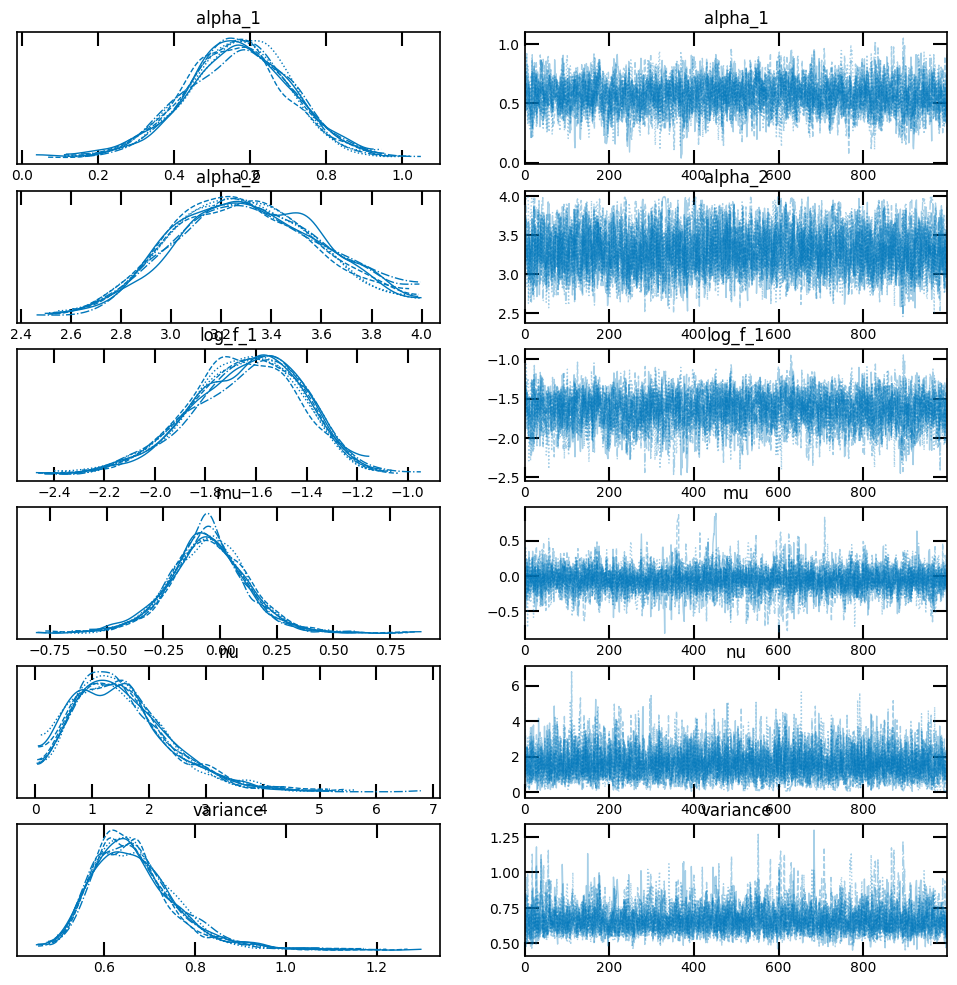

In [55]:
az.plot_trace(data)

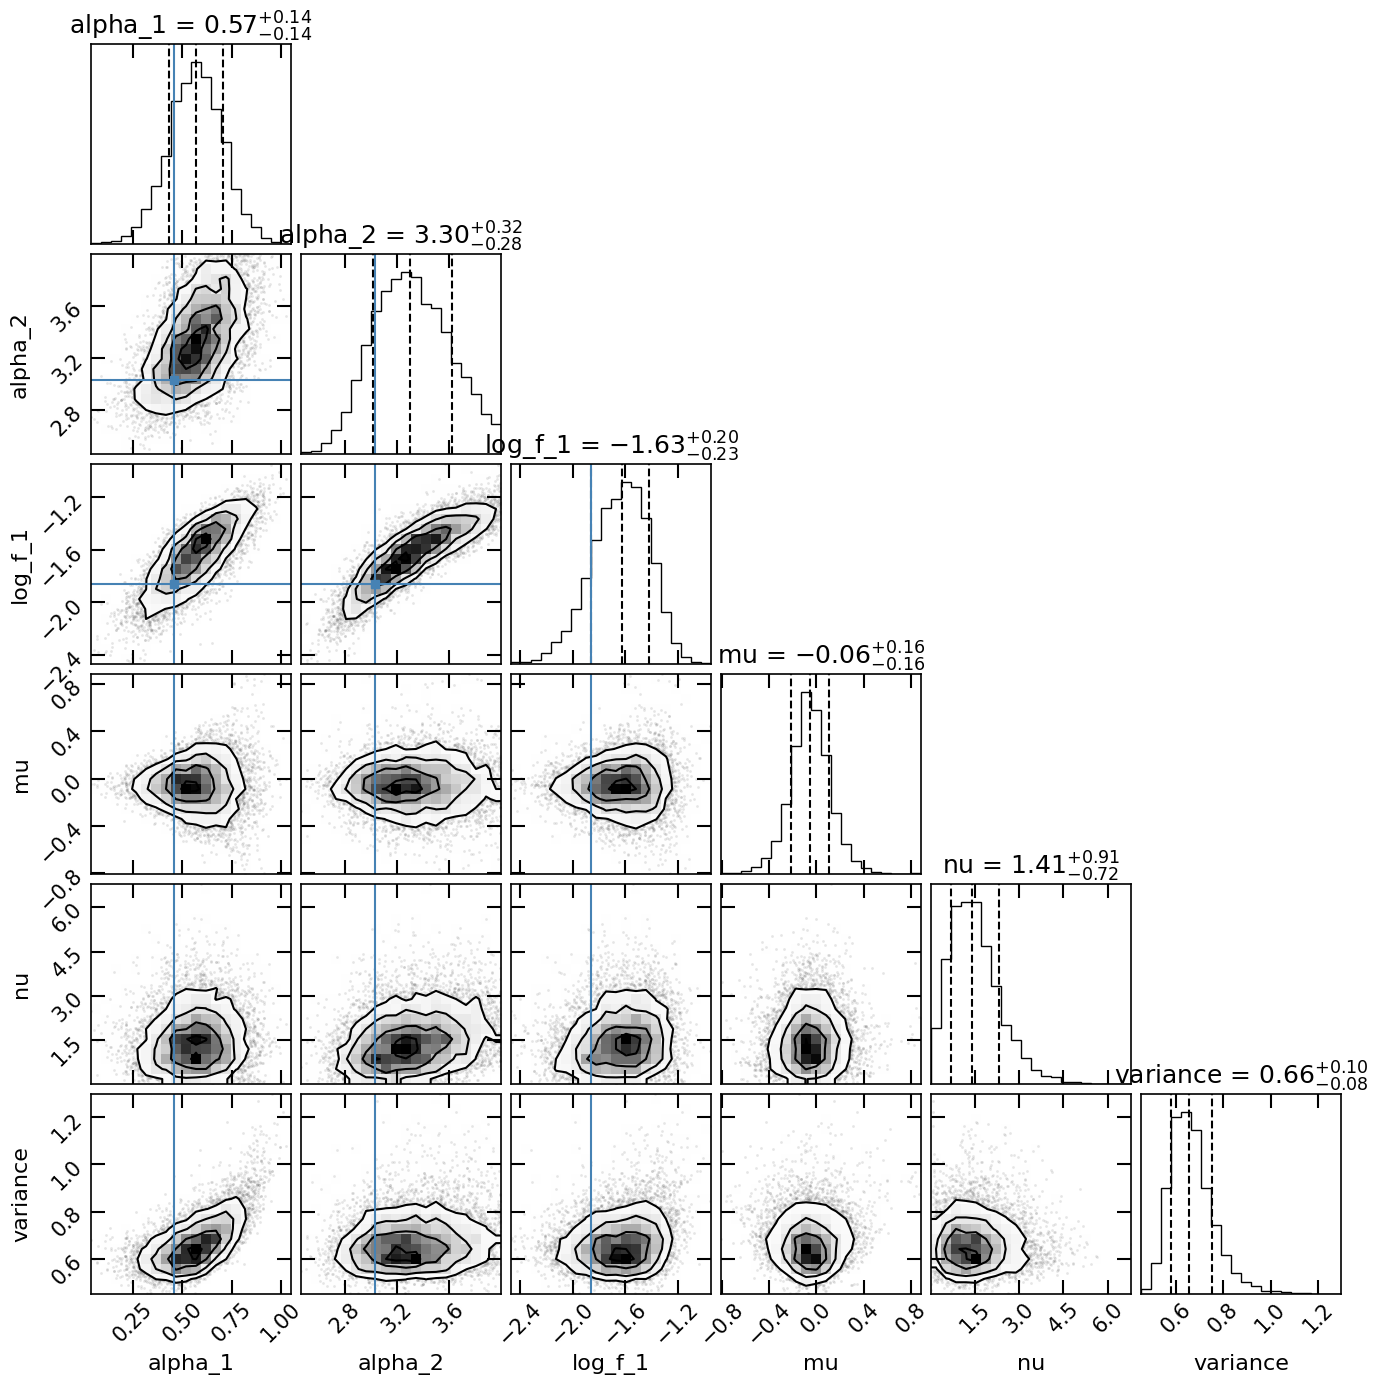

In [54]:
import corner

fig = corner.corner(
    data,
    quantiles=[0.16, 0.5, 0.84],
    truths={
        "alpha_1": 0.4593966,
        "alpha_2": 3.02679189,
        "log_f_1": np.log(0.15605791),
        "mu": None,
        "nu": None,
        "variance": None,
    },
    show_titles=True,
)